In [3]:
# all required imports
import json
from urllib.request import urlopen
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import matplotlib.pyplot as plt
import praw
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import numpy as np


%matplotlib inline

# Part I - Data Collection

In [ ]:
baseurl = 'https://api.pushshift.io/reddit/search/submission/?subreddit=india&sort=desc&sort_type=created_utc&'

period = 1 # in years

week_seconds = 7 * 24 * 60 * 60
week_count = 1
start_seconds = int(time.time()) - ((week_count - 1) * week_seconds) # start time of collection

all_data = []

while week_count <= int(period * 52):
    before, after = start_seconds, start_seconds - week_seconds
    url = baseurl + 'after={}&before={}&size=1000'.format(after, before)
    start_seconds = after
    r = urlopen(url).read()
    data = json.loads(r.decode('utf-8'))
    all_data += data['data']
    print(f'Week {week_count}/{period*52} done')
    week_count += 1
    
    
all_data_DF = pd.DataFrame(all_data)

#### The above collected data contains posts from ```r/india``` , 1000 posts per week of all flairs collected for a year(52 weeks) starting from the day of collection. All the post collected do not have flair associated with them, hence they need to be removed. This dataset doesn't contains comments for each post, PRAW will be used for obtaining the comments for the posts.

In [ ]:
all_data_DF = all_data_DF[all_data_DF.link_flair_text.notnull()]
all_data_DF.reset_index(drop=True, inplace=True)

reddit = praw.Reddit() 
# praw.ini file contains all the credentials, located in the same directory as this file.
def get_submission_comments(sub_url):    
    submission = reddit.submission(url=sub_url)
    submission.comments.replace_more(limit=0)
    comments = submission.comments.list()    
    if comments:
        all_comments = ' '.join([i.body for i in comments if i.body !='[deleted]'])
        return all_comments
    else:
        return ' '

## retreiving all comments for each post, if available    
for ind in range(len(all_data_DF)):
    if pd.isna(all_data_DF.iloc[ind].comments):
        try:
            comm = get_submission_comments(all_data_DF.iloc[ind].full_link)
        except:
            all_data_DF.loc[data.index[ind], 'comments'] = ' '
        else:
            all_data_DF.loc[data.index[ind], 'comments'] = comm

all_data_DF.to_csv('reddit_data.csv', index=False)

## Part-2 Exploratory Data Analysis(EDA)

#### The above datset has a lot of features , so only key features below have been used and these features are considered with valid reasons in terms of model training.
* title
* url
* selftext
* comments
* link_flair_text

In [10]:
keep_features = ['title','url', 'selftext', 'link_flair_text','comments']

In [11]:
all_data_DF = pd.read_csv('reddit_data.csv')

In [12]:
data = all_data_DF[keep_features] 

In [13]:
from collections import Counter
counts = Counter(data['link_flair_text'])
counts

Counter({'Coronavirus': 2092,
         'Non-Political': 7102,
         'Politics': 7798,
         'AskIndia': 4569,
         nan: 22026,
         'Photography': 847,
         'Business/Finance': 1886,
         'Science/Technology': 1340,
         'Food': 411,
         'CAA-NRC-NPR': 21,
         'Policy/Economy': 1403,
         'All CAPS.': 174,
         'Scheduled': 191,
         'Sports': 468,
         'Low-effort self-post.': 155,
         '| Not specific to India |': 22,
         '| Not in English |': 7,
         'Shitpost': 6,
         '| Low-effort Self Post |': 20,
         '| Not in English | | Unverified Content / Disreputed Source |': 1,
         '| Not specific to India | | Stickied Topic |': 1,
         'Low Quality/Non OC Meme': 10,
         '| Repost |': 46,
         '| Social Media Rules |': 18,
         '| Not Original/Relevant Title | | Custom (Informed OP) |': 1,
         'Meta.': 9,
         '| Custom (Informed OP) |': 3,
         '| Not Original/Relevant Title |': 3

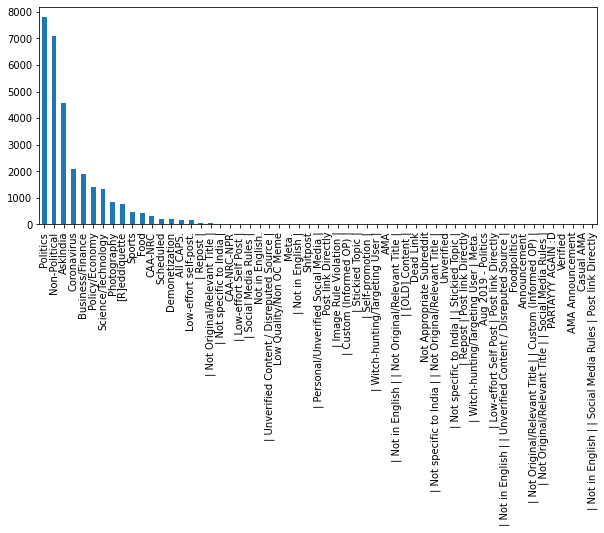

In [14]:
plt.figure(figsize=(10,4))
data.link_flair_text.value_counts().plot(kind='bar');

## Uni-grams for top n words before removing stop words

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(data['title'], 20)
for word, freq in common_words:
    print(word, freq)
    
unig = pd.DataFrame(common_words, columns = ['title' , 'count'])

in 15273
to 14994
the 13788
of 11447
india 8188
for 7449
and 7200
is 6193
on 5909
this 3291
with 3255
from 3212
it 2972
at 2790
indian 2708
you 2651
are 2634
by 2605
what 2517
how 2281


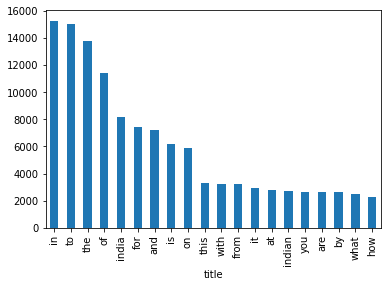

In [19]:
unig.groupby('title').sum()['count'].sort_values(ascending=False).plot(kind='bar')

## Uni-grams for top n words after removing stop words

In [20]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(data['title'], 10)
for word, freq in common_words:
    print(word, freq)
uni_post = pd.DataFrame(common_words, columns = ['title' , 'count'])

india 8188
indian 2708
2019 2023
delhi 1780
modi 1734
amp 1502
new 1491
says 1477
news 1474
people 1333


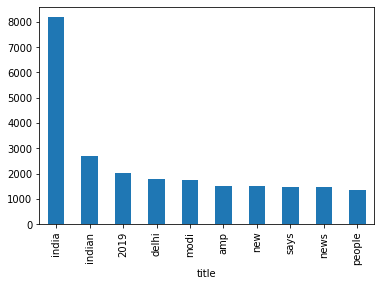

In [21]:
uni_post.groupby('title').sum()['count'].sort_values(ascending=False).plot(kind='bar')

## Bi-grams for top n words before removing stop words

In [22]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(data['title'], 10)
for word, freq in common_words:
    print(word, freq)
big = pd.DataFrame(common_words, columns = ['title' , 'count'])

in india 2102
of the 1241
in the 1153
of india 912
to be 690
covid 19 622
is the 549
on the 544
how to 515
to the 498


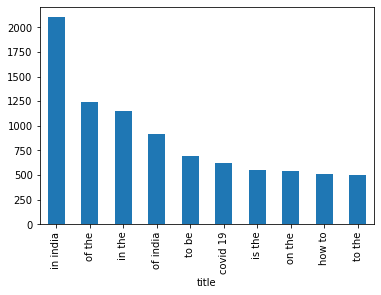

In [23]:
big.groupby('title').sum()['count'].sort_values(ascending=False).plot(kind='bar')

## Bi-grams for top n words after removing stop words

In [24]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(data['title'], 10)
for word, freq in common_words:
    print(word, freq)
big_post = pd.DataFrame(common_words, columns = ['title' , 'count'])

covid 19 622
world cup 387
pm modi 362
narendra modi 352
times india 323
year old 313
amit shah 262
rahul gandhi 253
supreme court 227
news times 204


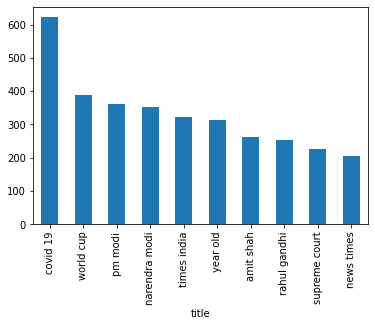

In [25]:
big_post.groupby('title').sum()['count'].sort_values(ascending=False).plot(kind='bar')

## Tri-grams for top n words before removing stop words

In [26]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(data['title'], 10)
for word, freq in common_words:
    print(word, freq)
tri= pd.DataFrame(common_words, columns = ['title' , 'count'])

times of india 311
news times of 204
what is the 134
what do you 132
do you think 132
one of the 129
world cup 2019 124
price in india 109
the big news 109
other top stories 109


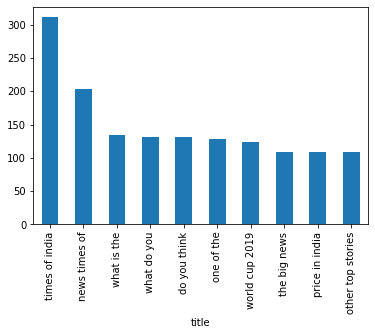

In [27]:
tri.groupby('title').sum()['count'].sort_values(ascending=False).plot(kind='bar')

## Tri-grams for top n words after removing stop words

In [28]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(data['title'], 10)
for word, freq in common_words:
    print(word, freq)
tri_post = pd.DataFrame(common_words, columns = ['title' , 'count'])

news times india 204
world cup 2019 124
random daily discussion 107
daily discussion thread 107
pm narendra modi 102
india news times 95
random discussion thread 73
late night random 71
night random discussion 71
2019 09 15am 71


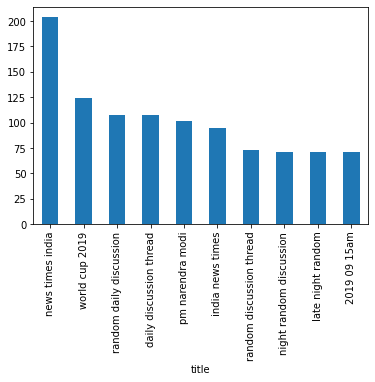

In [29]:
tri_post.groupby('title').sum()['count'].sort_values(ascending=False).plot(kind='bar')

## Most Correlated N-grams

In [32]:
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(data.title).toarray()
labels = data.link_flair_text
features.shape

N = 5
for flair, id in sorted(data.items()):
    features_chi2 = chi2(features, labels == id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(flair))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'link_flair_text':
  . Most correlated unigrams:
       . 19
       . coronavirus
       . cup
       . covid
       . songs
  . Most correlated bigrams:
       . hindi gan
       . result declared
       . big news
       . world cup
       . covid 19
# 'selftext':
  . Most correlated unigrams:
       . fingerprint
       . fingers
       . fingerstyle
       . findings
       . கள
  . Most correlated bigrams:
       . financial institutions
       . financial irregularities
       . fined rs
       . fingerless corrugation
       . fingers crossed
# 'title':
  . Most correlated unigrams:
       . 2019
       . modi
       . indian
       . india
       . photography
  . Most correlated bigrams:
       . times india
       . narendra modi
       . world cup
       . pm modi
       . covid 19
# 'url':
  . Most correlated unigrams:
       . fingerprint
       . fingers
       . fingerstyle
       . findings
       . கள
  . Most correlated bigrams:
       . financial institutions
     

## Top 10 parts of speech tagging for title 

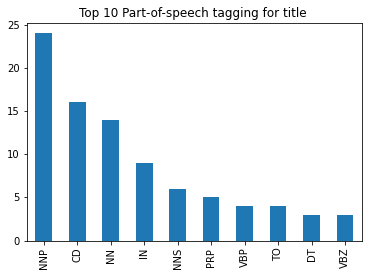

In [33]:
from textblob import TextBlob
blob = TextBlob(str(data['title']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:10]
pos_df.plot(kind='bar', title='Top 10 Part-of-speech tagging for title ')

## Topic Modelling with LSA

In [37]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix

reindexed_data = data['title']
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)
n_topics = 5
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [38]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [39]:
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [40]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)
top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  india news coronavirus
Topic 2:  2019 new hindi
Topic 3:  modi delhi bjp
Topic 4:  2020 thread discussion
Topic 5:  indian army media


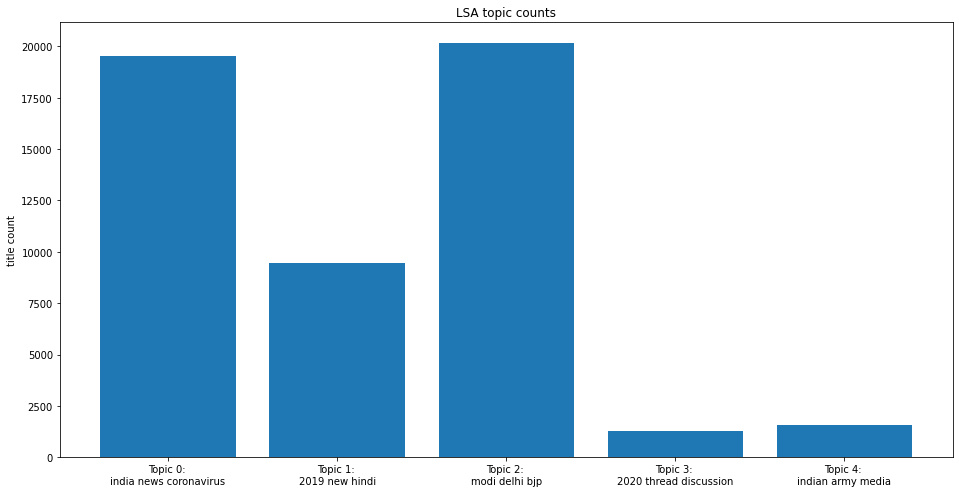

In [41]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('title count');
ax.set_title('LSA topic counts');
plt.show();

In [ ]:
selected_flairs = ["AskIndia", "Non-Political", "[R]eddiquette", "Photography", "Science/Technology", "Politics", "Business/Finance", "Policy/Economy", "Sports", "Food", "AMA", "Coronavirus"]
balanced_data = pd.DataFrame()

data = data[data.selftext.notnull()]
data = data[data.comments.notnull()]
data = data[data.url.notnull()]

for item in selected_flairs:
    temp = data[data.link_flair_text==item]
    temp = temp.head(200)
    balanced_data = pd.concat([balanced_data, temp], axis=0)
    
data = balanced_data

### Data Cleaning

#### For this balanced data set, our text cleaning step includes tokenizing the text, removing stop words, change text to lower case, remove punctuation, remove bad characters, and so on.

In [42]:
# max length of title in each flair category
len_title= int(data['title'].str.encode(encoding='utf-8').str.len().max())
len_title

721

In [45]:
# max length of selftext in each flair category
len_comm = int(data['selftext'].str.encode(encoding='utf-8').str.len().max())
len_comm

26790

In [49]:
STOPWORDS = set(stopwords.words('english'))

In [50]:
def cleaning(text):
    text = str(text).lower() 
    tokens  = word_tokenize(text)
    text = ' '.join(word for word in tokens if word not in STOPWORDS and word.isalpha()) 
    return text



def clean_url(url):
    non_uselful = ['http', 'https', 'www', 'com', 'reddit']
    add_ons = ['cms', 'comments', 'r', 'redd', 'google', 'amp', 'co', 'youtu', 'india', 'jpg', 'article', 'youtube', 'png', 'twitter']
    non_uselful += add_ons
    non_uselful = set(non_uselful)
    delimiters = [':', '/', '_', '-', '.']
    pattern = '|'.join(map(re.escape, delimiters))
    try:
        url = re.split(pattern,url)
    except:
        return ''
    else:
        url = ' '.join(word for word in url if word not in STOPWORDS and word.isalpha() and word not in non_uselful) 
        return url


In [51]:
data['title'] = data['title'].apply(cleaning)
data['selftext'] = data['selftext'].apply(cleaning)
data['url'] = data['url'].apply(clean_url)
data['comments'] = data['comments'].apply(cleaning)

data['content'] = data['title'].str.cat(data['selftext'], sep =" ") 
data['content'] = data['content'].str.cat(data['url'], sep =" ") 
data['content'] = data['content'].str.cat(data['comments'], sep =" ") 

In [52]:
# max length of title of each flair after removing stop words
len_title= int(data['title'].str.encode(encoding='utf-8').str.len().max())
len_title

232

In [53]:
# max length 
len_comm = int(data['comments'].str.encode(encoding='utf-8').str.len().max())
len_comm

338775

In [54]:
data = data[data.content!='']
data.reset_index(drop=True, inplace=True)

## Part-3 Building a Flair Detector

#### Random Forest showed the best testing accuracy of 78 when trained on the combination of content which is title + comments + Url + self_text feature.The dataset is split into 70% train and 30% test data using train-test-split of scikit-learn.

In [55]:
X = data.content
y = data.link_flair_text
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
flairs = list(set(data.link_flair_text))

## Naive-Bayes CLassifier

In [56]:
from sklearn.naive_bayes import MultinomialNB

naivebayes = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

naivebayes.fit(X_train, y_train)
y_pred = naivebayes.predict(X_test)


print('Accuracy %s' % accuracy_score(y_pred, y_test))

print(classification_report(y_test, y_pred,target_names=flairs))

Accuracy 0.5915279878971256
                    precision    recall  f1-score   support

               AMA       0.50      0.85      0.63        67
          Politics       0.40      0.48      0.44        54
Science/Technology       0.54      0.68      0.60        59
              Food       0.75      0.78      0.76        50
     Non-Political       0.78      0.71      0.74        59
    Policy/Economy       0.88      0.10      0.18        69
       Coronavirus       0.98      0.63      0.77        71
     [R]eddiquette       0.36      0.77      0.49        53
            Sports       0.57      0.45      0.51        55
       Photography       0.66      0.69      0.67        54
          AskIndia       0.91      0.51      0.65        63
  Business/Finance       0.00      0.00      0.00         7

          accuracy                           0.59       661
         macro avg       0.61      0.55      0.54       661
      weighted avg       0.67      0.59      0.58       661



/home/sushmitha/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Linear Support Vector Machine Classifier

In [57]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-4, random_state=42,max_iter=100, tol=None)),
               ])
sgd.fit(X_train, y_train)


y_pred = sgd.predict(X_test)

print('Accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=flairs))

Accuracy 0.7443267776096822
                    precision    recall  f1-score   support

               AMA       0.83      0.88      0.86        67
          Politics       0.60      0.59      0.60        54
Science/Technology       0.77      0.73      0.75        59
              Food       0.68      0.76      0.72        50
     Non-Political       0.74      0.88      0.81        59
    Policy/Economy       0.76      0.68      0.72        69
       Coronavirus       0.93      0.87      0.90        71
     [R]eddiquette       0.54      0.60      0.57        53
            Sports       0.64      0.53      0.58        55
       Photography       0.71      0.83      0.77        54
          AskIndia       0.89      0.76      0.82        63
  Business/Finance       1.00      0.71      0.83         7

          accuracy                           0.74       661
         macro avg       0.76      0.74      0.74       661
      weighted avg       0.75      0.74      0.74       661



## Logistic Regression

In [58]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('Accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=flairs))

/home/sushmitha/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy 0.7413010590015129
                    precision    recall  f1-score   support

               AMA       0.81      0.85      0.83        67
          Politics       0.53      0.56      0.54        54
Science/Technology       0.75      0.71      0.73        59
              Food       0.76      0.62      0.68        50
     Non-Political       0.81      0.92      0.86        59
    Policy/Economy       0.83      0.65      0.73        69
       Coronavirus       0.95      0.87      0.91        71
     [R]eddiquette       0.56      0.66      0.60        53
            Sports       0.69      0.56      0.62        55
       Photography       0.59      0.89      0.71        54
          AskIndia       0.89      0.79      0.84        63
  Business/Finance       1.00      0.71      0.83         7

          accuracy                           0.74       661
         macro avg       0.76      0.73      0.74       661
      weighted avg       0.76      0.74      0.74       661



## Random Forest Classifier

In [59]:
from sklearn.ensemble import RandomForestClassifier

ranfor = Pipeline([('vect', CountVectorizer()),
              ('tfidf', TfidfTransformer()),
              ('clf', RandomForestClassifier(n_estimators = 1000, random_state = 42, max_depth=100)),
             ])

ranfor.fit(X_train, y_train)
y_pred = ranfor.predict(X_test)


print('Accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=flairs))

Accuracy 0.8063540090771558
                    precision    recall  f1-score   support

               AMA       0.78      0.94      0.85        67
          Politics       0.84      0.67      0.74        54
Science/Technology       0.80      0.68      0.73        59
              Food       0.76      0.94      0.84        50
     Non-Political       0.88      0.90      0.89        59
    Policy/Economy       0.82      0.80      0.81        69
       Coronavirus       0.94      0.93      0.94        71
     [R]eddiquette       0.62      0.62      0.62        53
            Sports       0.72      0.62      0.67        55
       Photography       0.73      0.91      0.81        54
          AskIndia       0.93      0.83      0.87        63
  Business/Finance       1.00      0.71      0.83         7

          accuracy                           0.81       661
         macro avg       0.82      0.79      0.80       661
      weighted avg       0.81      0.81      0.80       661



## Multi Layer Perceptron (MLP)

In [60]:
from sklearn.neural_network import MLPClassifier

mlp = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('clf', MLPClassifier(hidden_layer_sizes=(30,30,30))),
                 ])
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
   
print('Accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=flairs))

Accuracy 0.5885022692889561
                    precision    recall  f1-score   support

               AMA       0.80      0.52      0.63        67
          Politics       0.33      0.35      0.34        54
Science/Technology       0.65      0.58      0.61        59
              Food       0.64      0.58      0.61        50
     Non-Political       0.62      0.83      0.71        59
    Policy/Economy       0.74      0.36      0.49        69
       Coronavirus       0.86      0.76      0.81        71
     [R]eddiquette       0.29      0.64      0.40        53
            Sports       0.62      0.36      0.46        55
       Photography       0.58      0.78      0.67        54
          AskIndia       0.73      0.68      0.70        63
  Business/Finance       1.00      0.71      0.83         7

          accuracy                           0.59       661
         macro avg       0.65      0.60      0.60       661
      weighted avg       0.64      0.59      0.59       661



## Bag of Words (BOW) with Keras

In [ ]:
import itertools
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

data = shuffle(data)
train_size = int(len(data) * 0.7)
train_posts = data['content'][:train_size]
train_tags = data['link_flair_text'][:train_size]


test_posts = data['content'][train_size:]
test_tags = data['link_flair_text'][train_size:]

max_words = 5000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 30

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.3)
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)

print('Test Accuracy:', score[1])

/home/sushmitha/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sushmitha/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sushmitha/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sushmitha/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty


Train on 1078 samples, validate on 463 samples
Epoch 1/30
1078/1078 [==============================] - 2s 2ms/step - loss: 2.4531 - accuracy: 0.1994 - val_loss: 1.9634 - val_accuracy: 0.5076
Epoch 2/30
1078/1078 [==============================] - 2s 2ms/step - loss: 1.5009 - accuracy: 0.6280 - val_loss: 1.6510 - val_accuracy: 0.5767
Epoch 3/30
1078/1078 [==============================] - 2s 2ms/step - loss: 0.7751 - accuracy: 0.8293 - val_loss: 1.4084 - val_accuracy: 0.6825
Epoch 4/30
1078/1078 [==============================] - 2s 1ms/step - loss: 0.5664 - accuracy: 0.8915 - val_loss: 1.9766 - val_accuracy: 0.6177
Epoch 5/30
1078/1078 [==============================] - 2s 1ms/step - loss: 0.3019 - accuracy: 0.9378 - val_loss: 1.7542 - val_accuracy: 0.6955
Epoch 6/30
1078/1078 [==============================] - 2s 2ms/step - loss: 0.3085 - accuracy: 0.9536 - val_loss: 1.9312 - val_accuracy: 0.6695
Epoch 7/30
1078/1078 [==============================] - 2s 2ms/step - loss: 0.2606 - acc